# Experimentation Script
This script is used for evaluation on the dataset, and evaluate on the effect of different models on an image instance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cv2
from tqdm import tqdm

# Reading in data

In [2]:
dist = pd.read_csv('./resnet101_matches_distance.csv').values
fname = pd.read_csv('./resnet101_matches_filename.csv').values

good = pd.read_csv('./sift_matches_distance.csv').values
fgood = pd.read_csv('./sift_matches_filename.csv').values

In [3]:
color = pd.read_csv('./color_matches_distance.csv').values
fcolor = pd.read_csv('./color_matches_filename.csv').values

In [4]:
train_i = {}
test_i = {}

train_xy = pd.read_csv('train.csv')
train_path = train_xy['id'].values
test_path = pd.read_csv('imagenames.csv')['id'].values

for f in train_path:
    i = cv2.imread('./train/' + f + '.jpg')
    train_i[f] = i
for f in test_path:
    i = cv2.imread('./test/' + f + '.jpg')
    test_i[f] = i

# Train Distribution

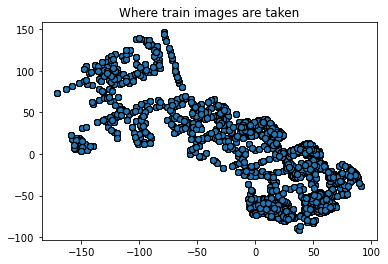

In [5]:
plt.scatter(train_xy['x'],train_xy['y'],edgecolors='black')
plt.title('Where train images are taken')
plt.show()

# Testing on basic models
To toggle the experimental models, the following variables can be changed:
* `i`: The index of the test image on the test dataset, in the order of `imagenames.csv`
* `top`: Number of top best candidates to plot out

In [47]:
# Get the coordinate of a training image
get_coord = lambda name: train_xy.loc[train_xy['id']==name,['x','y']].values

# Get all CNN matches within a top range for a test instance, defined by a threshold
extract_match = lambda i, thresh: fname[i,np.argwhere(dist[i] < dist[i,0] + thresh)]

# Get all corresponding metric given a file name
map_fname = lambda i,dist,fnames,f :dist[0,np.argwhere(fnames[i,:] == f)][0,0]

## Top SIFT Candidates

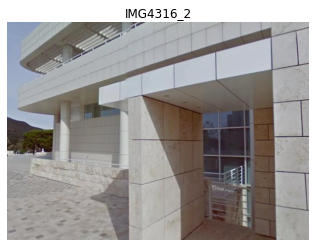

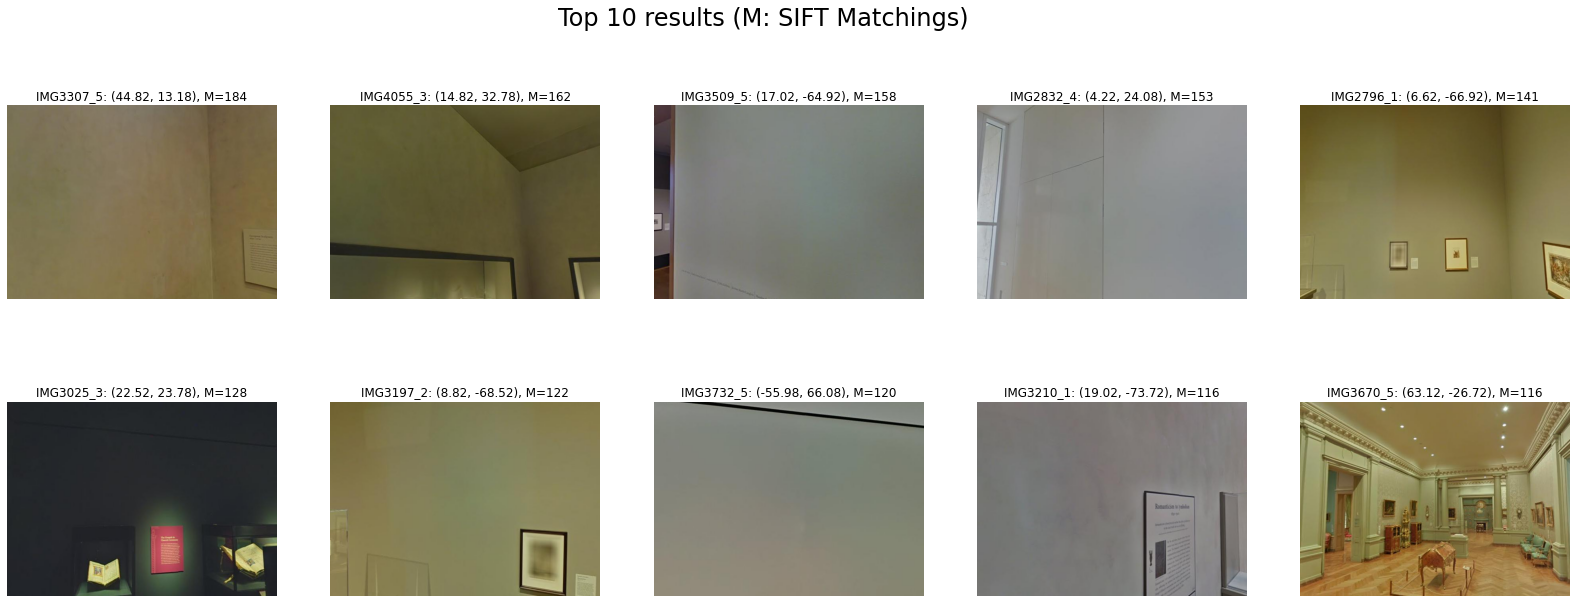

In [138]:
i=29
top = 10
test_img = test_i[test_path[i]]
train_res = fgood[i,:top]

plt.imshow(test_img[:,:,::-1])
plt.title(f'{test_path[i]}')
plt.axis('off')
plt.show()

_,ax = plt.subplots(int(top/5),5,figsize=(28,5*int(top/5)))
plt.suptitle(f'Top {top} results (M: SIFT Matchings)', fontsize=24)
for j,train in enumerate(train_res):
    train_img = train_i[train]
    coor = get_coord(train)
    ax[int(j/5),j%5].imshow(train_img[:,:,::-1])
    ax[int(j/5),j%5].set_title(f'{train}: ({coor[0,0]:.2f}, {coor[0,1]:.2f}), M={good[i,j]:.0f}')
    ax[int(j/5),j%5].axis('off')

## Top CNN Candidates

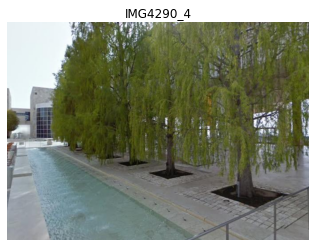

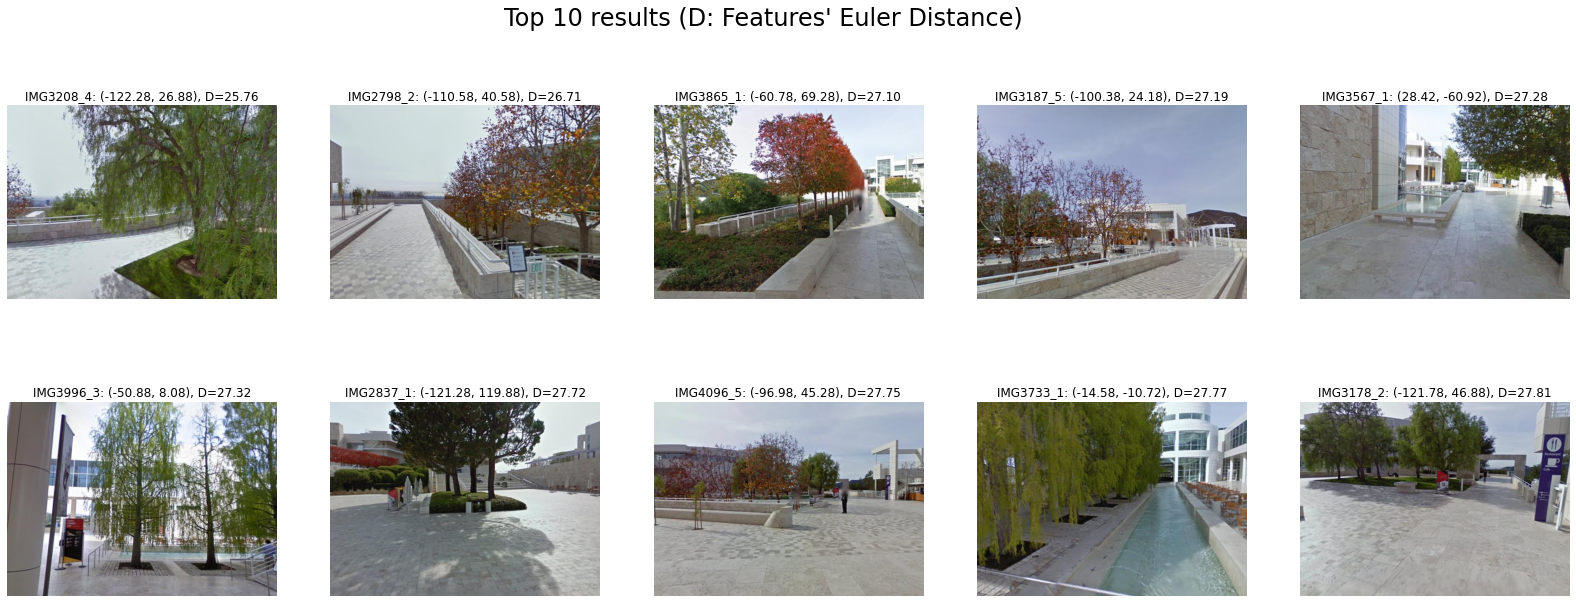

In [141]:
i=3
top = 10

test_img = test_i[test_path[i]]
train_res = fname[i,:top]

plt.imshow(test_img[:,:,::-1])
plt.title(f'{test_path[i]}')
plt.axis('off')
plt.show()

_,ax = plt.subplots(int(top/5),5,figsize=(28,5*int(top/5)))
plt.suptitle(f'Top {top} results (D: Features\' Euler Distance)', fontsize=24)
for j,train in enumerate(train_res):
    train_img = train_i[train]
    coor = get_coord(train)
    ax[int(j/5),j%5].imshow(train_img[:,:,::-1])
    ax[int(j/5),j%5].set_title(f'{train}: ({coor[0,0]:.2f}, {coor[0,1]:.2f}), D={dist[i,j]:.2f}')
    ax[int(j/5),j%5].axis('off')

## Top color matching candidates

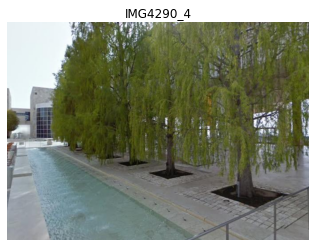

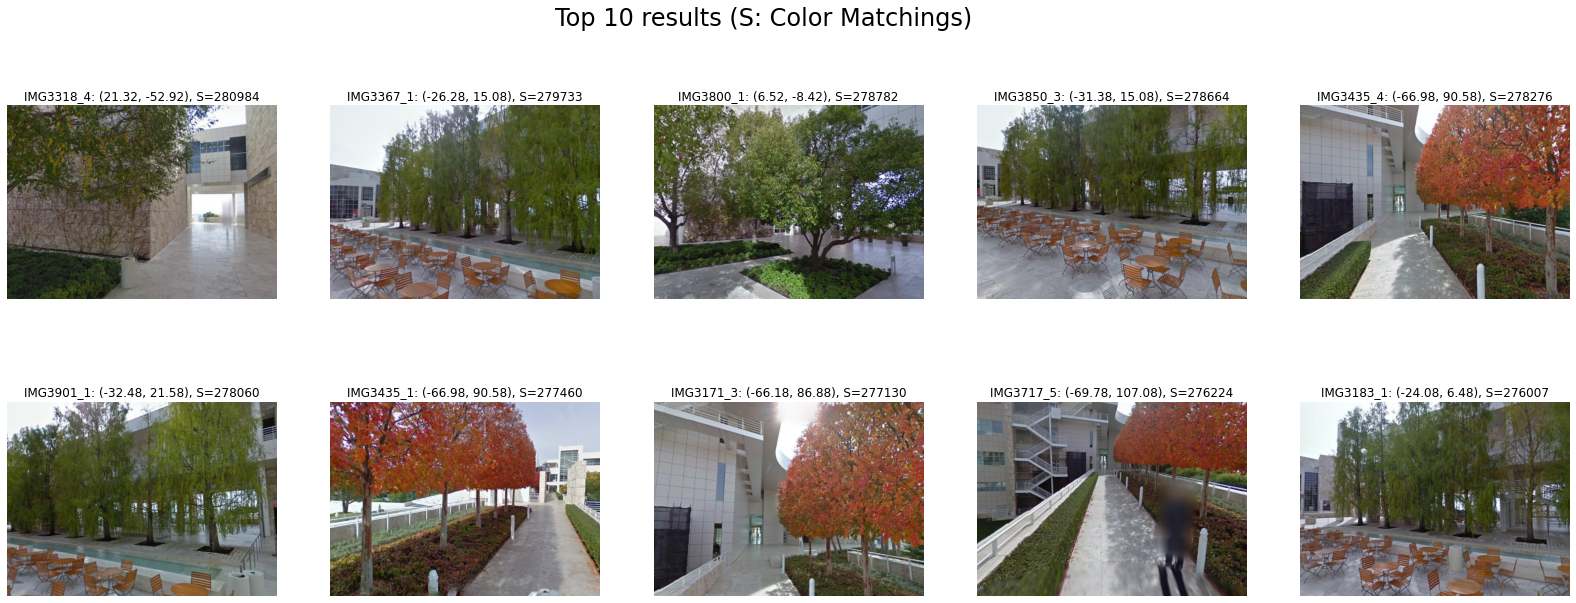

In [17]:
i=3
top = 10
test_img = test_i[test_path[i]]
train_res = fcolor[i,:top]

plt.imshow(test_img[:,:,::-1])
plt.title(f'{test_path[i]}')
plt.axis('off')
plt.show()

_,ax = plt.subplots(int(top/5),5,figsize=(28,5*int(top/5)))
plt.suptitle(f'Top {top} results (S: Color Matchings)', fontsize=24)
for j,train in enumerate(train_res):
    train_img = train_i[train]
    coor = get_coord(train)
    ax[int(j/5),j%5].imshow(train_img[:,:,::-1])
    ax[int(j/5),j%5].set_title(f'{train}: ({coor[0,0]:.2f}, {coor[0,1]:.2f}), S={color[i,j]:.0f}')
    ax[int(j/5),j%5].axis('off')

## Ranked by CNN Similarity, on top of SIFT Candidates
* Change `limit` to set how many top SIFT Candidates to take from

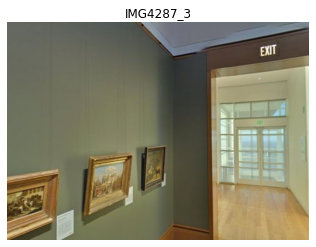

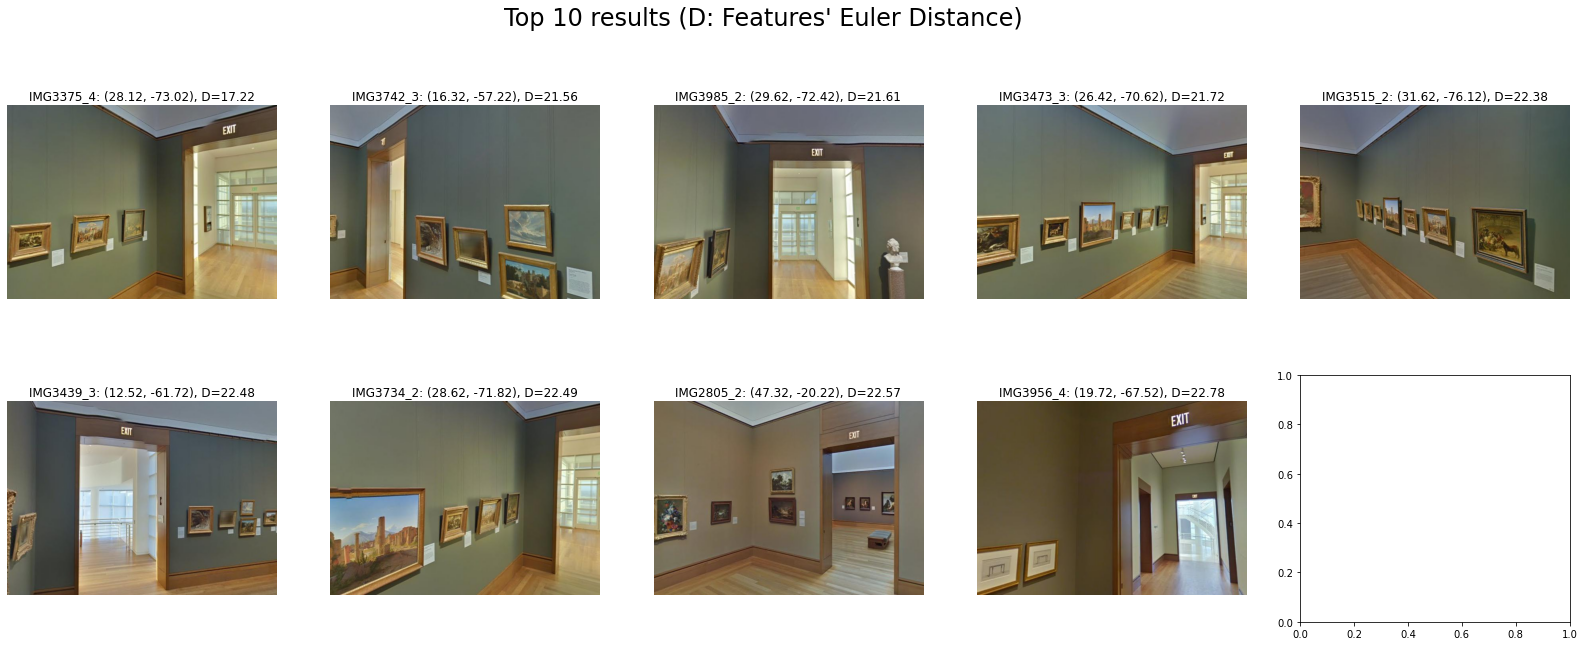

In [143]:
i=0
top = 10
limit = 1500

test_img = test_i[test_path[i]]
train_res = fname[i,:top]

plt.imshow(test_img[:,:,::-1])
plt.title(f'{test_path[i]}')
plt.axis('off')
plt.show()

top_sift = fgood[i,:limit]

_,ax = plt.subplots(int(top/5),5,figsize=(28,5*int(top/5)))
plt.suptitle(f'Top {top} results (D: Features\' Euler Distance)', fontsize=24)
j = 0
for train in train_res:
    if j == top: break
    if train not in top_sift: continue
    train_img = train_i[train]
    coor = get_coord(train)
    ax[int(j/5),j%5].imshow(train_img[:,:,::-1])
    ax[int(j/5),j%5].set_title(f'{train}: ({coor[0,0]:.2f}, {coor[0,1]:.2f}), D={dist[i,j]:.2f}')
    ax[int(j/5),j%5].axis('off')
    j += 1

## Ranked by SIFT, on top CNN candidates
* Change `threshold` to set the top range of CNN candidates to take from

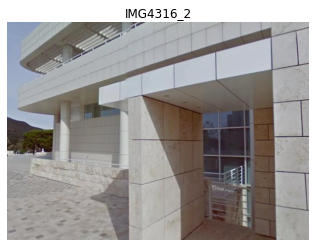

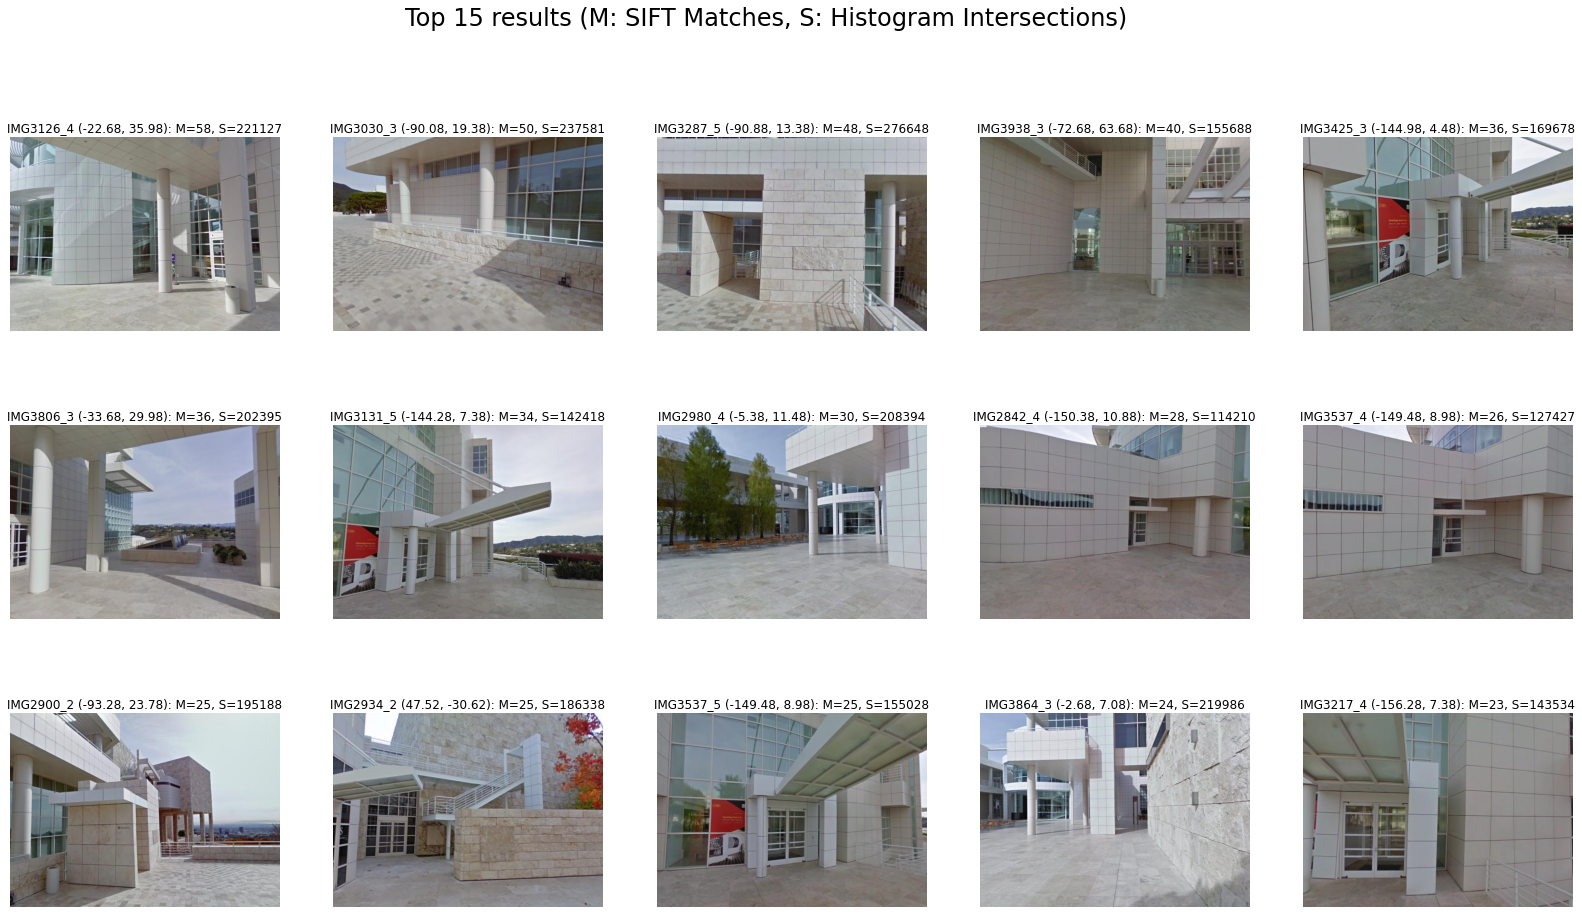

In [16]:
i=29
top = 15
threshold = 5

test_img = test_i[test_path[i]]
train_res = fgood[i,:]

plt.imshow(test_img[:,:,::-1])
plt.title(f'{test_path[i]}')
plt.axis('off')
plt.show()

top_cnn = extract_match(i,threshold).flatten()

hist_test = cv2.calcHist([test_img],[0],None,[256],[0,256])

_,ax = plt.subplots(int(top/5),5,figsize=(28,5*int(top/5)))
plt.suptitle(f'Top {top} results (M: SIFT Matches, S: Histogram Intersections)', fontsize=24)
j = 0
for idx,train in enumerate(train_res):
    if j == top: break
    if train not in top_cnn: continue
    train_img = train_i[train]
    hist_train = cv2.calcHist([train_img],[0],None,[256],[0,256])
    hist_intersection = cv2.compareHist(hist_train,hist_test,cv2.HISTCMP_INTERSECT)
    coor = get_coord(train)
    ax[int(j/5),j%5].imshow(train_img[:,:,::-1])
    ax[int(j/5),j%5].set_title(f'{train} ({coor[0,0]:.2f}, {coor[0,1]:.2f}): M={good[i,idx]:.0f}, S={hist_intersection:.0f}')
    ax[int(j/5),j%5].axis('off')
    j += 1

## Ranked by Color Similarity, on top CNN candidates
* Change `threshold` to set the top range of CNN candidates to take from

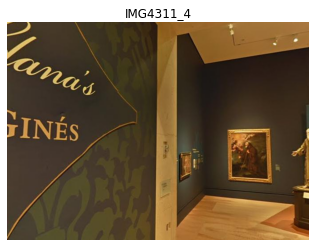

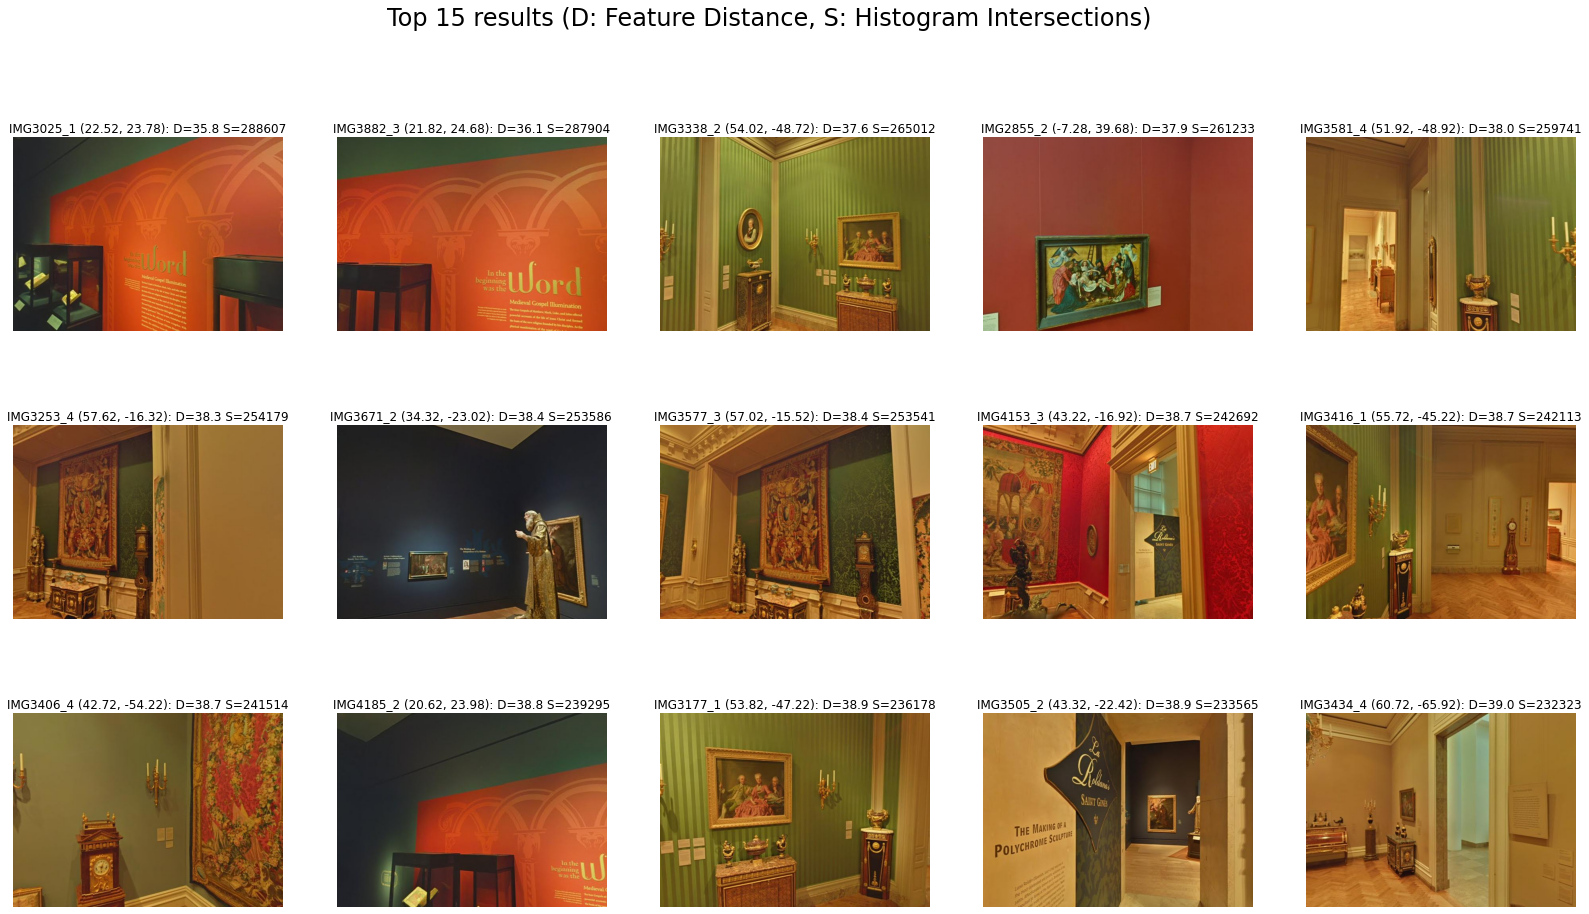

In [10]:
i = 24
top = 15
threshold = 6

test_img = test_i[test_path[i]]
train_res = fcolor[i,:]

plt.imshow(test_img[:,:,::-1])
plt.title(f'{test_path[i]}')
plt.axis('off')
plt.show()

top_cnn = extract_match(i,threshold).flatten()

hist_test = cv2.calcHist([test_img],[0],None,[256],[0,256])

_,ax = plt.subplots(int(top/5),5,figsize=(28,5*int(top/5)))
plt.suptitle(f'Top {top} results (D: Feature Distance, S: Histogram Intersections)', fontsize=24)
j = 0
for idx,train in enumerate(train_res):
    if j == top: break
    if train not in top_cnn: continue
    train_img = train_i[train]
    coor = get_coord(train)
    ax[int(j/5),j%5].imshow(train_img[:,:,::-1])
    ax[int(j/5),j%5].set_title(f'{train} ({coor[0,0]:.2f}, {coor[0,1]:.2f}): D={dist[i,idx]:.1f} S={color[i,idx]:.0f}')
    ax[int(j/5),j%5].axis('off')
    j += 1

## Given center, take the best CNN candidates, then filter out small SIFT matches, and take the top matches

In [151]:
def get_center_best(i, center, radius, max_count, n, min_match):
    '''Get the top SIFT matched results that is near center and has enough matches

    Params
    ---
    - i: index of test instance
    - center: test instance's chosen center
    - radius: cluster radius
    - max_count: number of top instaces to take

    Returns
    ---
    - cluster_filenames: filenames of the cluster elements
    - cluster_locations: locations of the cluster elements
    '''
    count = 0
    cluster_fs = []
    cluster_locs = []
    cluster_matches = []
    # Return empty if no matches
    if fname[i,0] is np.nan: return cluster_fs, cluster_locs
    # Get all top cnn candidates within radius
    for tr in fname[i]:
        if count == max_count: break
        train_loc = get_coord(tr)
        if np.sum((train_loc-center)**2)**0.5 < radius:
            cluster_fs.append(tr)
            cluster_locs.append(train_loc)
            cluster_matches.append(map_fname(i,good,fgood,tr))
            count += 1

    # Filtering out results with too few matches
    idx_filter = [idx for idx in range(count) if cluster_matches[idx]>min_match]
    idx_sorted = np.flip(np.argsort(cluster_matches))
    indicies = []
    icount = 0
    # Get the top n with good enough matches
    for idx in idx_sorted:
        if idx in idx_filter:
            indicies.append(idx)
            icount += 1
            if icount == n: break
    fs_res = [cluster_fs[idx] for idx in indicies]
    loc_res = [cluster_locs[idx] for idx in indicies]
    return fs_res,loc_res

cluster_centroids = pd.read_csv('Results/COCK_SIFT_voted_5_5_5_15_1_04_imputed.csv')

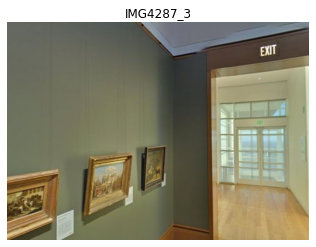

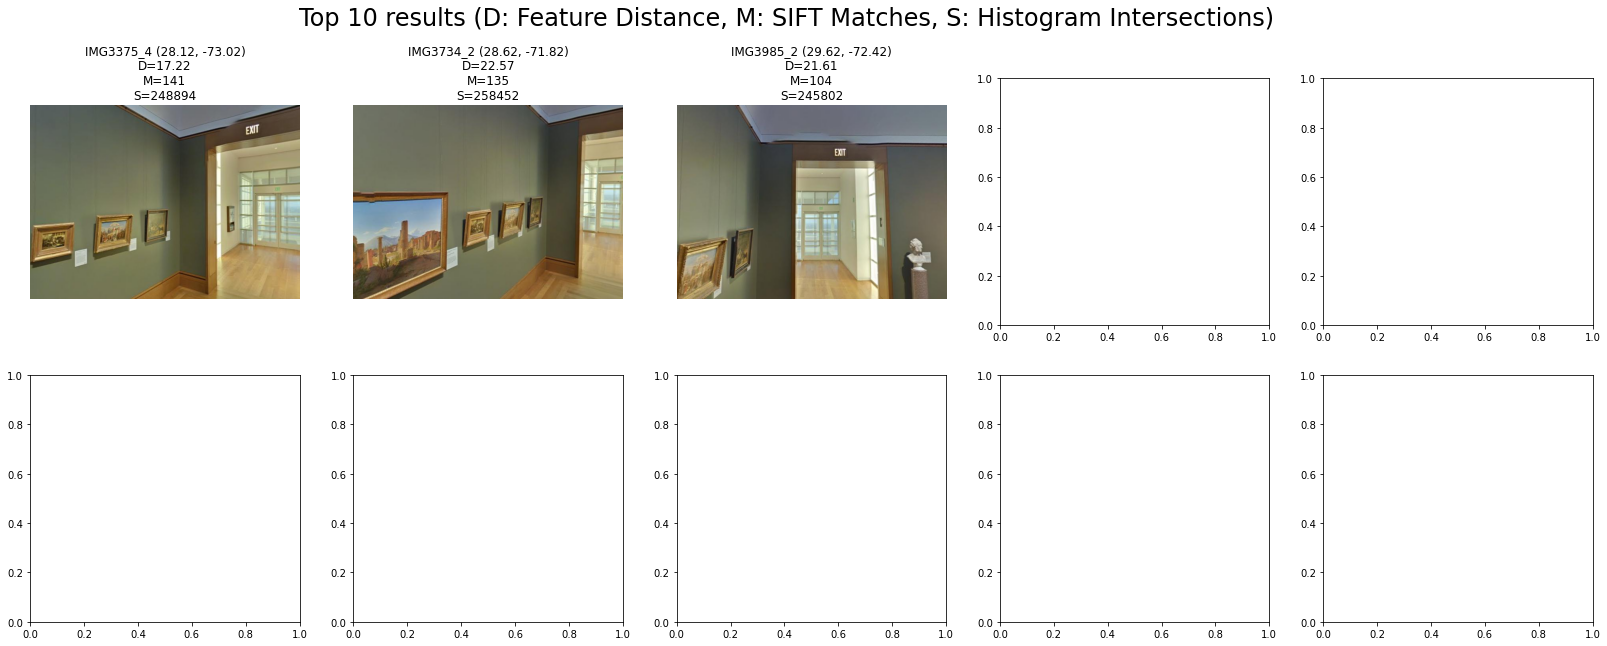

In [156]:
i = 0
max_count = 10

radius = 10
ratio = 0.65
max_range = 3
max_displacement = 7

n = 3
min_match = 30

test_img = test_i[test_path[i]]

plt.imshow(test_img[:,:,::-1])
plt.title(f'{test_path[i]}')
plt.axis('off')
plt.show()

center = cluster_centroids.iloc[i][['x','y']].values
fs,_ = get_center_best(i, center, radius, max_count, n, min_match)

_,ax = plt.subplots(int(max_count/5),5,figsize=(28,5*int(max_count/5)))
plt.suptitle(f'Top {max_count} results (D: Feature Distance, M: SIFT Matches, S: Histogram Intersections)', fontsize=24)
for j,train in enumerate(fs):
    train_img = train_i[train]
    coor = get_coord(train)
    ax[int(j/5),j%5].imshow(train_img[:,:,::-1])
    ax[int(j/5),j%5].set_title(f'{train} ({coor[0,0]:.2f}, {coor[0,1]:.2f})\n'
        f'D={map_fname(i,dist,fname,train):.2f}\nM={map_fname(i,good,fgood,train):.0f}\nS={map_fname(i,color,fcolor,train):.0f}')
    ax[int(j/5),j%5].axis('off')
    j += 1